# Train a ready to use TensorFlow model with a simple pipeline

In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

# the following line is not required if BatchFlow is installed as a python package.
sys.path.append("../..")
from batchflow import Pipeline, B, C, D, F, V
from batchflow.opensets import MNIST, CIFAR10, CIFAR100
from batchflow.models.tf import ResNet18

BATCH_SIZE might be increased for modern GPUs with lots of memory (4GB and higher).

In [2]:
BATCH_SIZE = 65

Specify which GPU(s) to be used. More about it in [CUDA documentation](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#env-vars).

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5


By default, batchflow pipeline models use all available GPUs.

# Create a dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits frequently used as a baseline for machine learning tasks.

Downloading MNIST database might take a few minutes to complete.

In [4]:
dataset = MNIST(bar=True)

100%|██████████| 8/8 [00:01<00:00,  4.00it/s]


There are also predefined CIFAR10 and CIFAR100 datasets.

# Define a pipeline config

Config allows to create flexible pipelines which take parameters.

For instance, if you put a model type into config, you can run a pipeline against different models.

See [a list of available models](https://analysiscenter.github.io/batchflow/intro/tf_models.html#ready-to-use-models) to choose the one which fits you best.

In [5]:
config = dict(model=ResNet18)

# Create a template pipeline

A template pipeline is not linked to any dataset. It's just an abstract sequence of actions, so it cannot be executed, but it serves as a convenient building block.

In [6]:
train_template = (Pipeline()
                .init_variable('loss_history', [])
                .init_model('dynamic', C('model'), 'conv_nn',
                             config={'inputs/images/shape': B.image_shape,
                                     'inputs/labels/classes': D.num_classes,
                                     'initial_block/inputs': 'images'})
                .to_array()
                .train_model('conv_nn', fetches='loss', images=B.images, labels=B.labels,
                             save_to=V('loss_history', mode='a'))
)

Save the model in after pipeline.

In [7]:
(train_template.after
 .save_model('conv_nn', path='path/to/save'))

# Train the model

Apply a dataset and a config to a template pipeline to create a runnable pipeline:

In [8]:
train_pipeline = (train_template << dataset.train) << config

Run the pipeline (it might take from a few minutes to a few hours depending on your hardware)

In [9]:
train_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=True, bar=True, prefetch=1)

100%|██████████| 923/923 [02:04<00:00,  7.39it/s]


Note that the progress bar often increments by 2 at a time - that's prefetch in action.

It does not give much here, though, since almost all time is spent in model training which is performed under a thread-lock one batch after another without any parallelism (otherwise the model would not learn anything as different batches would rewrite one another's model weights updates).

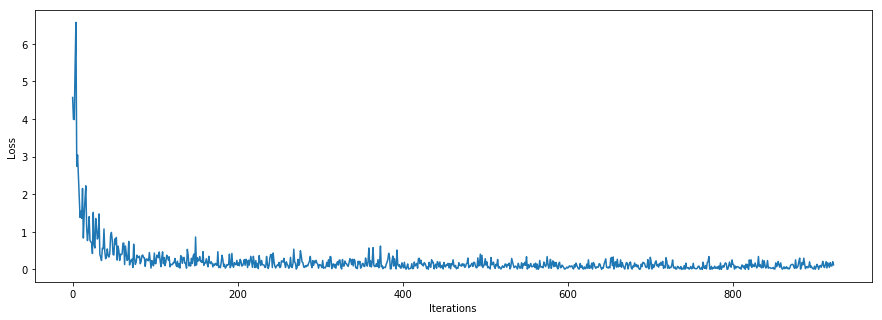

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(train_pipeline.v('loss_history'))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

# Test the model

It is much faster than training, but if you don't have GPU it would take some patience.

In [11]:
test_pipeline = (dataset.test.p
                .to_array()
                .predict_model('conv_nn', fetches='predictions', images=B.images, save_to=V('predictions'))
                .gather_metrics('class', targets=B.labels, predictions=V('predictions'),
                                fmt='logits', axis=-1, save_to=V('metrics', mode='a'))
)

In [12]:
(test_pipeline.before
 .init_variables('metrics', 'predictions')
 .import_model('conv_nn', train_pipeline))

In [13]:
test_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, drop_last=False, bar=True)

100%|██████████| 154/154 [00:04<00:00, 31.78it/s]


Let's get the accumulated [metrics information](https://analysiscenter.github.io/batchflow/intro/models.html#model-metrics)

In [14]:
metrics = test_pipeline.get_variable('metrics')

Or a shorter version: `metrics = test_pipeline.v('metrics')`

Now we can easiliy calculate any metrics we need

In [15]:
metrics.evaluate('accuracy')

0.9728090091726458

In [16]:
metrics.evaluate(['false_positive_rate', 'false_negative_rate'], multiclass=None)

{'false_negative_rate': array([0.01410752, 0.        , 0.04642396, 0.01775407, 0.07478683,
        0.01814832, 0.00960392, 0.03310969, 0.0306409 , 0.0272397 ]),
 'false_positive_rate': array([0.0019994 , 0.00793756, 0.00033504, 0.00316325, 0.00056918,
        0.00220208, 0.00278169, 0.00188534, 0.00134165, 0.00819108])}

## Another way to save the model
After learning the model, you also can save it. It's easy to do this.

In [17]:
train_pipeline.save_model_now('conv_nn', path='path/to/save')

## What's next?

See [the image augmentation tutorial](./06_image_augmentation.ipynb) or return to the [table of contents](./00_description.ipynb).